In [1]:
import os

os.chdir('../')

print(os.getcwd())

c:\Users\tolayi1\Documents\GitHub\compositional_model


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from source.plotters import Plotters, disp_shap_violin, disp_shap_bar

In [3]:
plotter = Plotters()

In [4]:
def show_prediction(model, 
                    X_train, X_test, 
                    y_train, y_test, 
                    fontsize=15, dpi =600, figsize=(6, 6)):

    plt.figure(figsize=figsize)
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                            ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['figure.dpi'] = dpi

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    plt.scatter(y_pred_train, y_train, marker='o', alpha=0.5, color='r')
    plt.scatter(y_pred_test, y_test, marker='*', alpha=0.5, color='b')

    plt.plot([0, 30], [0, 30], 'k-', lw=2)


    plt.legend([r'$ \rm Train$', r'$ \rm Test$', r'$ \rm R^{2}=1$'], loc='best', frameon=False, fontsize=fontsize)
    plt.xlabel(r'$ \rm Pred. Λ_{resin}$') #plt.xlabel('Model Resin Conductivity (mS/cm)')
    plt.ylabel(r'$ \rm Exp. Λ_{resin}$') #('Experimental Resin Conductivity (mS/cm)')

    plt.show()

In [5]:
def plot_metrics(model, 
                 fontsize=15, dpi = 600, figsize=(6, 6)):

    plt.figure(figsize=figsize)
    # plot log loss
    plt.rcParams['mathtext.fontset'] = 'cm'
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"
                                                ] + plt.rcParams["font.serif"]
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['figure.dpi'] = dpi
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    
    plt.plot(x_axis, results['validation_0']['rmse'], label=r'$ \rm Train$', lw=2)
    plt.plot(x_axis, results['validation_1']['rmse'], label=r'$ \rm Valid$', lw=2)
    plt.legend(loc='best', frameon=False, fontsize=fontsize)
    plt.ylabel(r'$ \rm RMSE$') #plt.ylabel('RMSE')
    plt.xlabel(r'$ \rm Epochs$') #plt.xlabel('Epochs')
    plt.title(r'$ \rm Loss$') #plt.title('Loss')
    plt.show()

In [6]:
resin_data = pd.read_excel('./data/processed/ResinModeling.xlsx', sheet_name='Arges-etal-ResinWafer-orig', header=0)
resin_data.head()

,SN,Wafer_description,wafer,Porosity,IEC (meq/g),IEC (meq/mL),Density (g/mL),concentration (g/L),conductivity
0,1,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,0.046910,1.774474
1,2,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,0.403166,3.007252
2,3,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,3.467062,7.094421
3,4,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,4.901728,8.272385
4,5,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,8.377341,10.684912


In [7]:
resin_data['concentration (mol/m3)'] = resin_data['concentration (g/L)'].apply(lambda x: x*1000/(35.45+23))
resin_data.head()

,SN,Wafer_description,wafer,Porosity,IEC (meq/g),IEC (meq/mL),Density (g/mL),concentration (g/L),conductivity,concentration (mol/m3)
0,1,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,0.046910,1.774474,0.802564
1,2,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,0.403166,3.007252,6.897629
2,3,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,3.467062,7.094421,59.316708
3,4,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,4.901728,8.272385,83.861904
4,5,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,8.377341,10.684912,143.324910


In [8]:
import numpy as np

def cond(C):
    '''  
        params:
            C: concentration of the solution, mol/m3. 
        return: 
            k: conductivity of the diluated solution, S/m (1 S/m = 10 mS/cm)
        ref: 
            Wright et al. 2018 & Ortiz et al. 2005
        '''
    B0 = 0.3277 # unitless
    B1 = 0.2271 # unitless
    B2 = 54.164 # unitless
    lambda0 = 126.4 # cm^2-S/mol
    u = 4.0 # Angstrom
    lambda_ = lambda0 - (B1 * lambda0 + B2) * np.sqrt(C * 1e-3) / (1 + B0 * u * np.sqrt(C * 1e-3)) # cm^2-S/mol, c (mol/m3)
    k = (C * lambda_ * 1e-4) # S-m^2/mol, added 1e-4 to convert cm^2-S/mol to m^2-S/mol
    # rh = k / L # S/m^2
    return  k * 10 # mS/cm

In [9]:
resin_data['solution conductivity (mS/cm)'] = resin_data['concentration (mol/m3)'].apply(lambda x: cond(x))
resin_data.head()

,SN,Wafer_description,wafer,Porosity,IEC (meq/g),IEC (meq/mL),Density (g/mL),concentration (g/L),conductivity,concentration (mol/m3),solution conductivity (mS/cm)
0,1,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,0.046910,1.774474,0.802564,0.099627
1,2,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,0.403166,3.007252,6.897629,0.829048
2,3,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,3.467062,7.094421,59.316708,6.590158
3,4,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,4.901728,8.272385,83.861904,9.141363
4,5,Mixed resin with PE binder,1,0.265,0.69,0.93012,1.348,8.377341,10.684912,143.324910,15.111065


In [10]:
data = resin_data[['concentration (mol/m3)', 'IEC (meq/mL)', 'solution conductivity (mS/cm)', 'Porosity', 'conductivity']]
print(data.shape)
data.head()

(49, 5)


,concentration (mol/m3),IEC (meq/mL),solution conductivity (mS/cm),Porosity,conductivity
0,0.802564,0.93012,0.099627,0.265,1.774474
1,6.897629,0.93012,0.829048,0.265,3.007252
2,59.316708,0.93012,6.590158,0.265,7.094421
3,83.861904,0.93012,9.141363,0.265,8.272385
4,143.324910,0.93012,15.111065,0.265,10.684912


In [11]:
X = data[['concentration (mol/m3)', 'solution conductivity (mS/cm)', 'Porosity', 'IEC (meq/mL)']].values # , 'solution conductivity (mS/cm)'
y = data[['conductivity']].values

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 42
test_size = 0.2

# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# create a validation set
X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=test_size, random_state=seed, shuffle=True)


In [13]:
cols = [
        r'$ \rm C_{sol}$', 
        r'$ \rm Λ_{sol}$',
        r'$ \rm \phi$',
        r'$ \rm IEC_{resin}$']

In [14]:
# For shapely
X_train_shapely = pd.DataFrame(X_train, columns=['concentration (mol/m3)', 'solution conductivity (mS/cm)', 'Porosity', 'IEC (meq/mL)'])
print(X_train_shapely.shape)
X_full_shapely = pd.DataFrame(scaler.transform(X), columns=['concentration (mol/m3)', 'solution conductivity (mS/cm)', 'Porosity', 'IEC (meq/mL)'])
print(X_full_shapely.shape)

(31, 4)
(49, 4)


In [15]:
X_train_shapely_sampled = X_train_shapely.sample(20, random_state=10)


In [16]:
# set columns
X_train_shapely_sampled.columns = cols
X_full_shapely.columns = cols
X_train_shapely.columns = cols

In [17]:
import shap

# # Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j, model=None, S=X_train_shapely_sampled):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

# reference: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

# XGBoost

https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt



In [41]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

# Define hyperparameters grid
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor
xgb = XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
# merge the training and validation set
X_train_ = np.concatenate((X_train, X_vali), axis=0)
y_train_ = np.concatenate((y_train, y_vali), axis=0)
grid_search.fit(X_train_, y_train_)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}


## 1. No early stop

In [42]:
# fit model no training data
model_no_earl_stop = XGBRegressor(**best_params)
eval_set = [(X_train, y_train), (X_vali, y_vali)]
model_no_earl_stop.fit(X_train, y_train, eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model_no_earl_stop.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = r2_score(y_test, predictions)
print(f"R^2: {accuracy:.2f}")

[0]	validation_0-rmse:6.88921	validation_1-rmse:4.90569
[1]	validation_0-rmse:6.65089	validation_1-rmse:4.71256
[2]	validation_0-rmse:6.39601	validation_1-rmse:4.57294
[3]	validation_0-rmse:6.19437	validation_1-rmse:4.45233
[4]	validation_0-rmse:6.00345	validation_1-rmse:4.34190
[5]	validation_0-rmse:5.82635	validation_1-rmse:4.27630
[6]	validation_0-rmse:5.65894	validation_1-rmse:4.19163
[7]	validation_0-rmse:5.51743	validation_1-rmse:4.08759
[8]	validation_0-rmse:5.34863	validation_1-rmse:3.96522
[9]	validation_0-rmse:5.18007	validation_1-rmse:3.87723
[10]	validation_0-rmse:5.11091	validation_1-rmse:3.82658
[11]	validation_0-rmse:5.05132	validation_1-rmse:3.81348
[12]	validation_0-rmse:4.90799	validation_1-rmse:3.70537
[13]	validation_0-rmse:4.75584	validation_1-rmse:3.57488
[14]	validation_0-rmse:4.57753	validation_1-rmse:3.45372
[15]	validation_0-rmse:4.43429	validation_1-rmse:3.41273
[16]	validation_0-rmse:4.25979	validation_1-rmse:3.31533
[17]	validation_0-rmse:4.12019	validation

[29]	validation_0-rmse:2.82118	validation_1-rmse:2.49285
[30]	validation_0-rmse:2.73358	validation_1-rmse:2.44043
[31]	validation_0-rmse:2.63411	validation_1-rmse:2.38611
[32]	validation_0-rmse:2.55750	validation_1-rmse:2.35758
[33]	validation_0-rmse:2.46809	validation_1-rmse:2.31021
[34]	validation_0-rmse:2.37617	validation_1-rmse:2.27257
[35]	validation_0-rmse:2.30202	validation_1-rmse:2.22083
[36]	validation_0-rmse:2.27816	validation_1-rmse:2.20111
[37]	validation_0-rmse:2.25849	validation_1-rmse:2.18537
[38]	validation_0-rmse:2.19391	validation_1-rmse:2.16366
[39]	validation_0-rmse:2.13753	validation_1-rmse:2.13321
[40]	validation_0-rmse:2.08498	validation_1-rmse:2.11898
[41]	validation_0-rmse:2.02674	validation_1-rmse:2.07438
[42]	validation_0-rmse:2.00940	validation_1-rmse:2.06400
[43]	validation_0-rmse:1.94908	validation_1-rmse:2.03158
[44]	validation_0-rmse:1.90066	validation_1-rmse:2.01123
[45]	validation_0-rmse:1.84764	validation_1-rmse:2.00101
[46]	validation_0-rmse:1.81913	

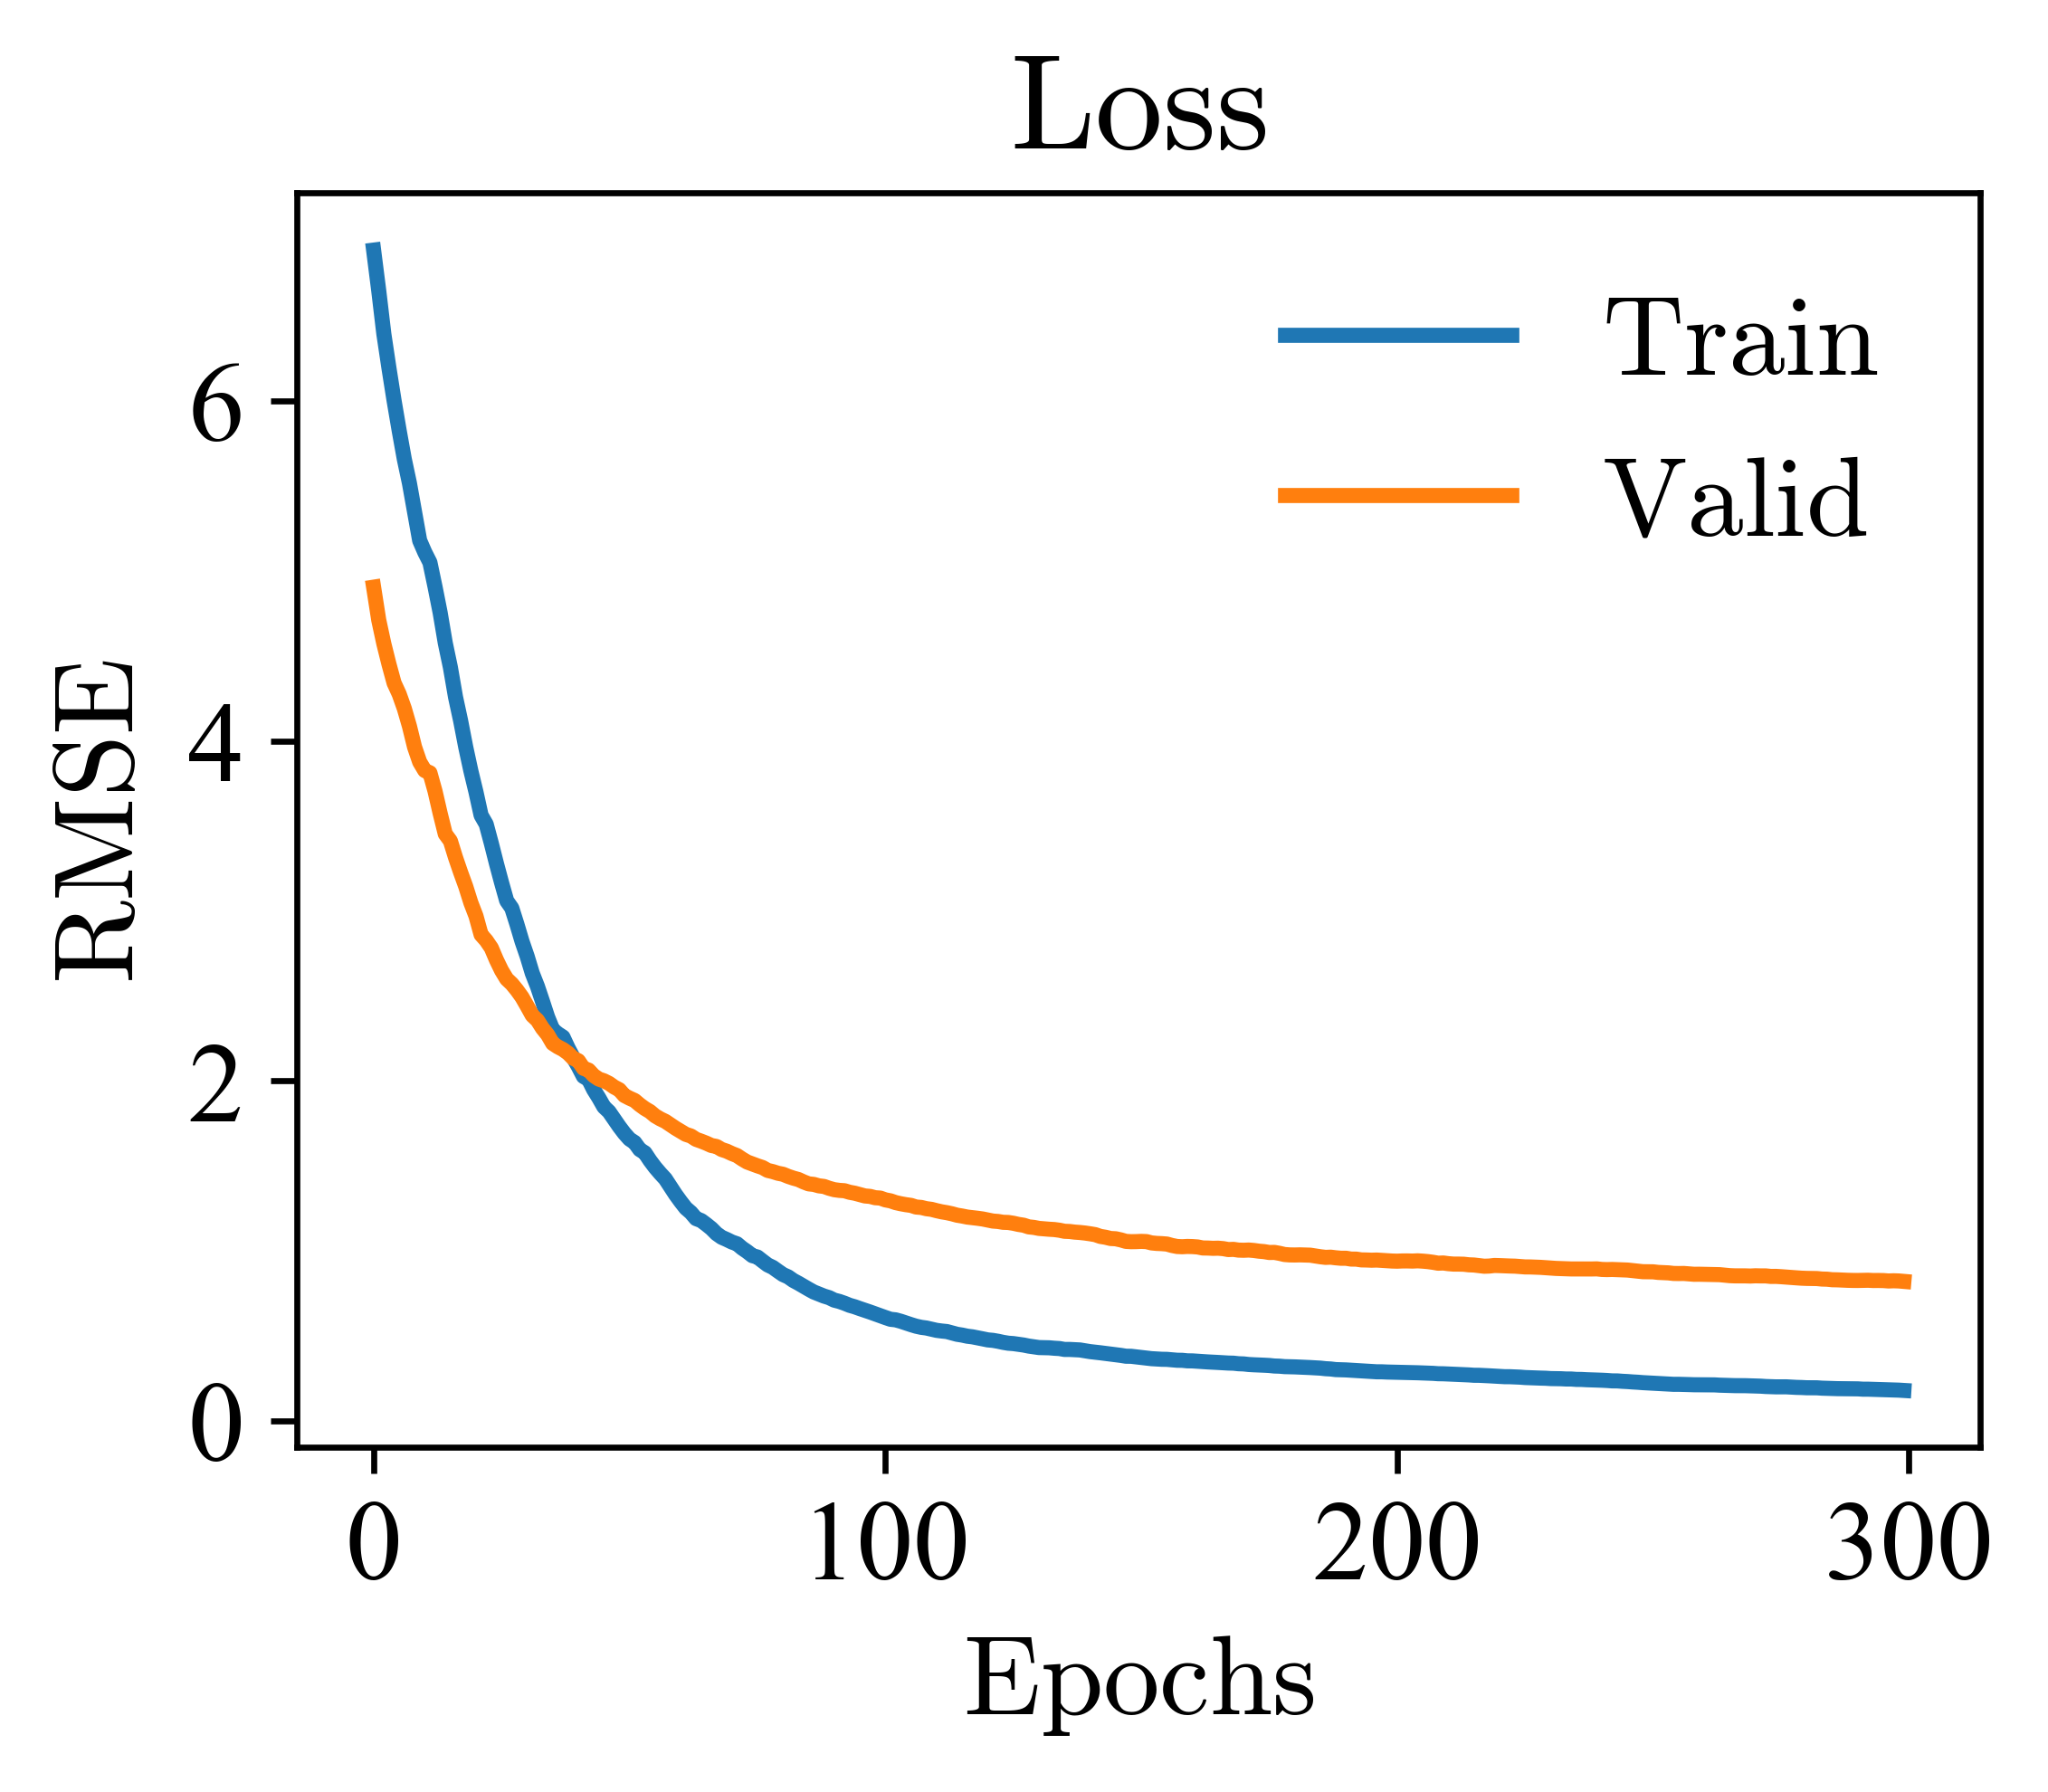

In [43]:
plot_metrics(model_no_earl_stop, fontsize=15, dpi=600, figsize=(4, 3))

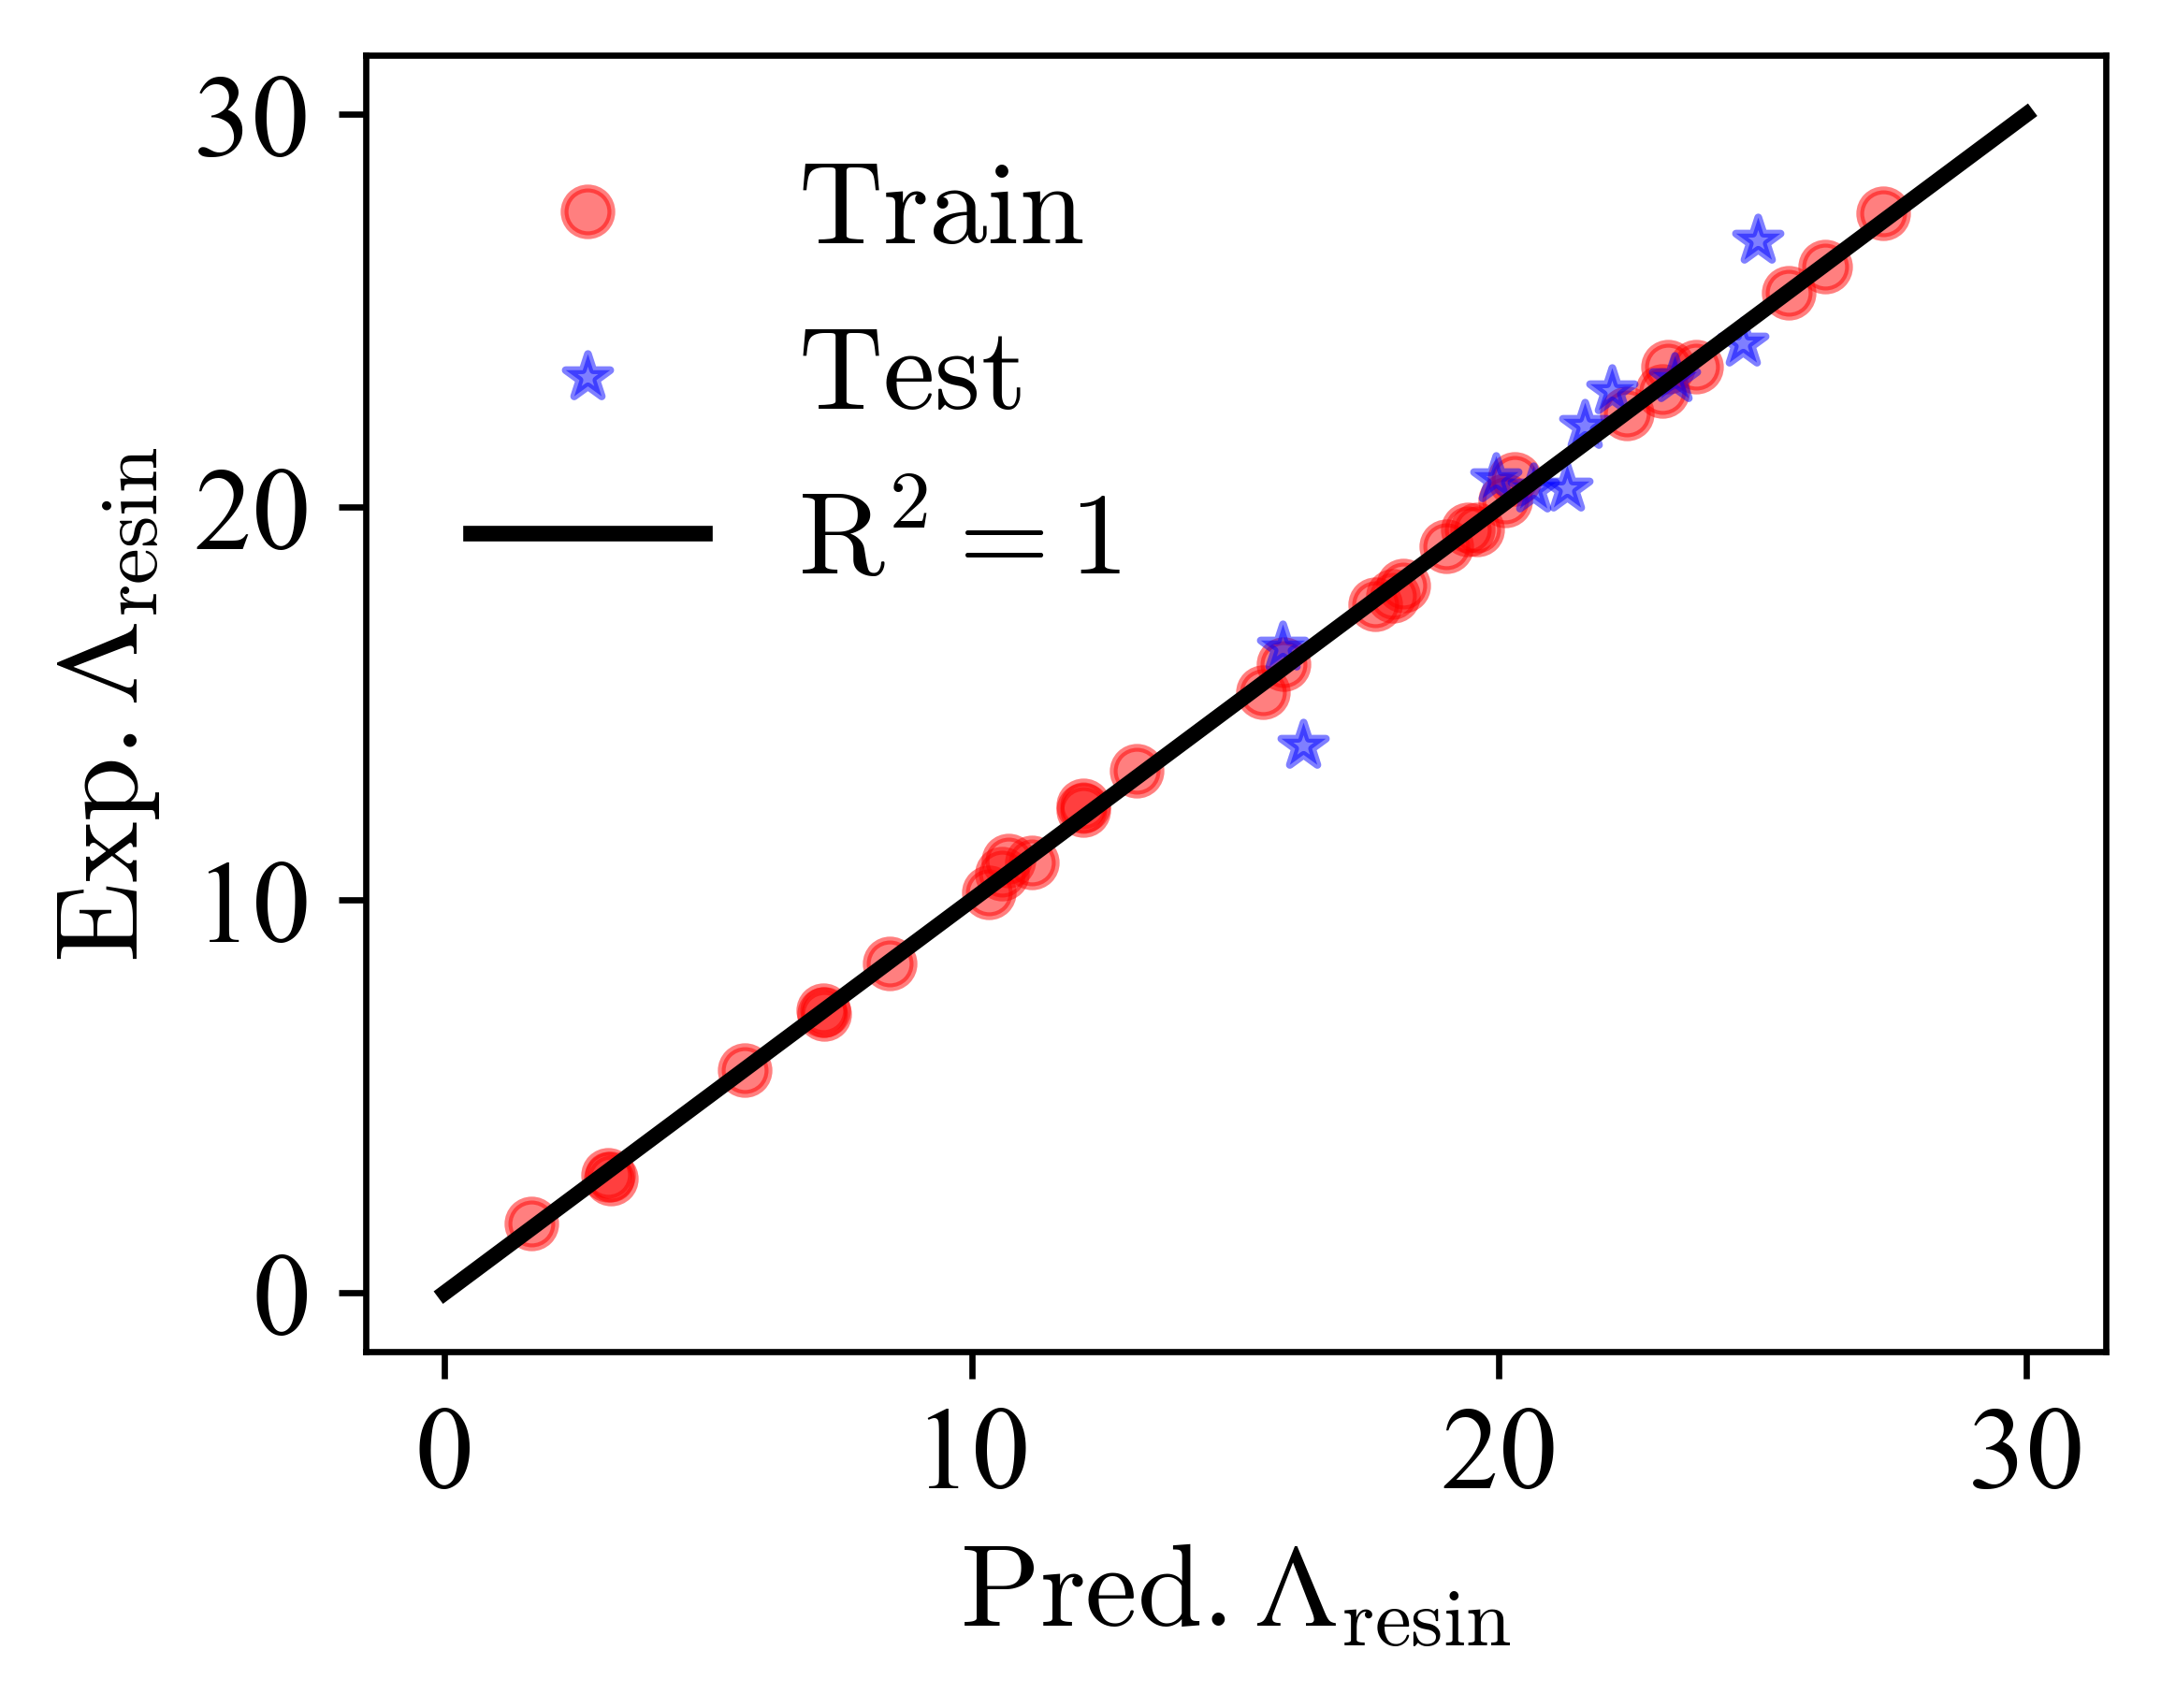

In [44]:
show_prediction(model_no_earl_stop, X_train, X_test, y_train, y_test, fontsize=15, figsize=(4, 3))

[11:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


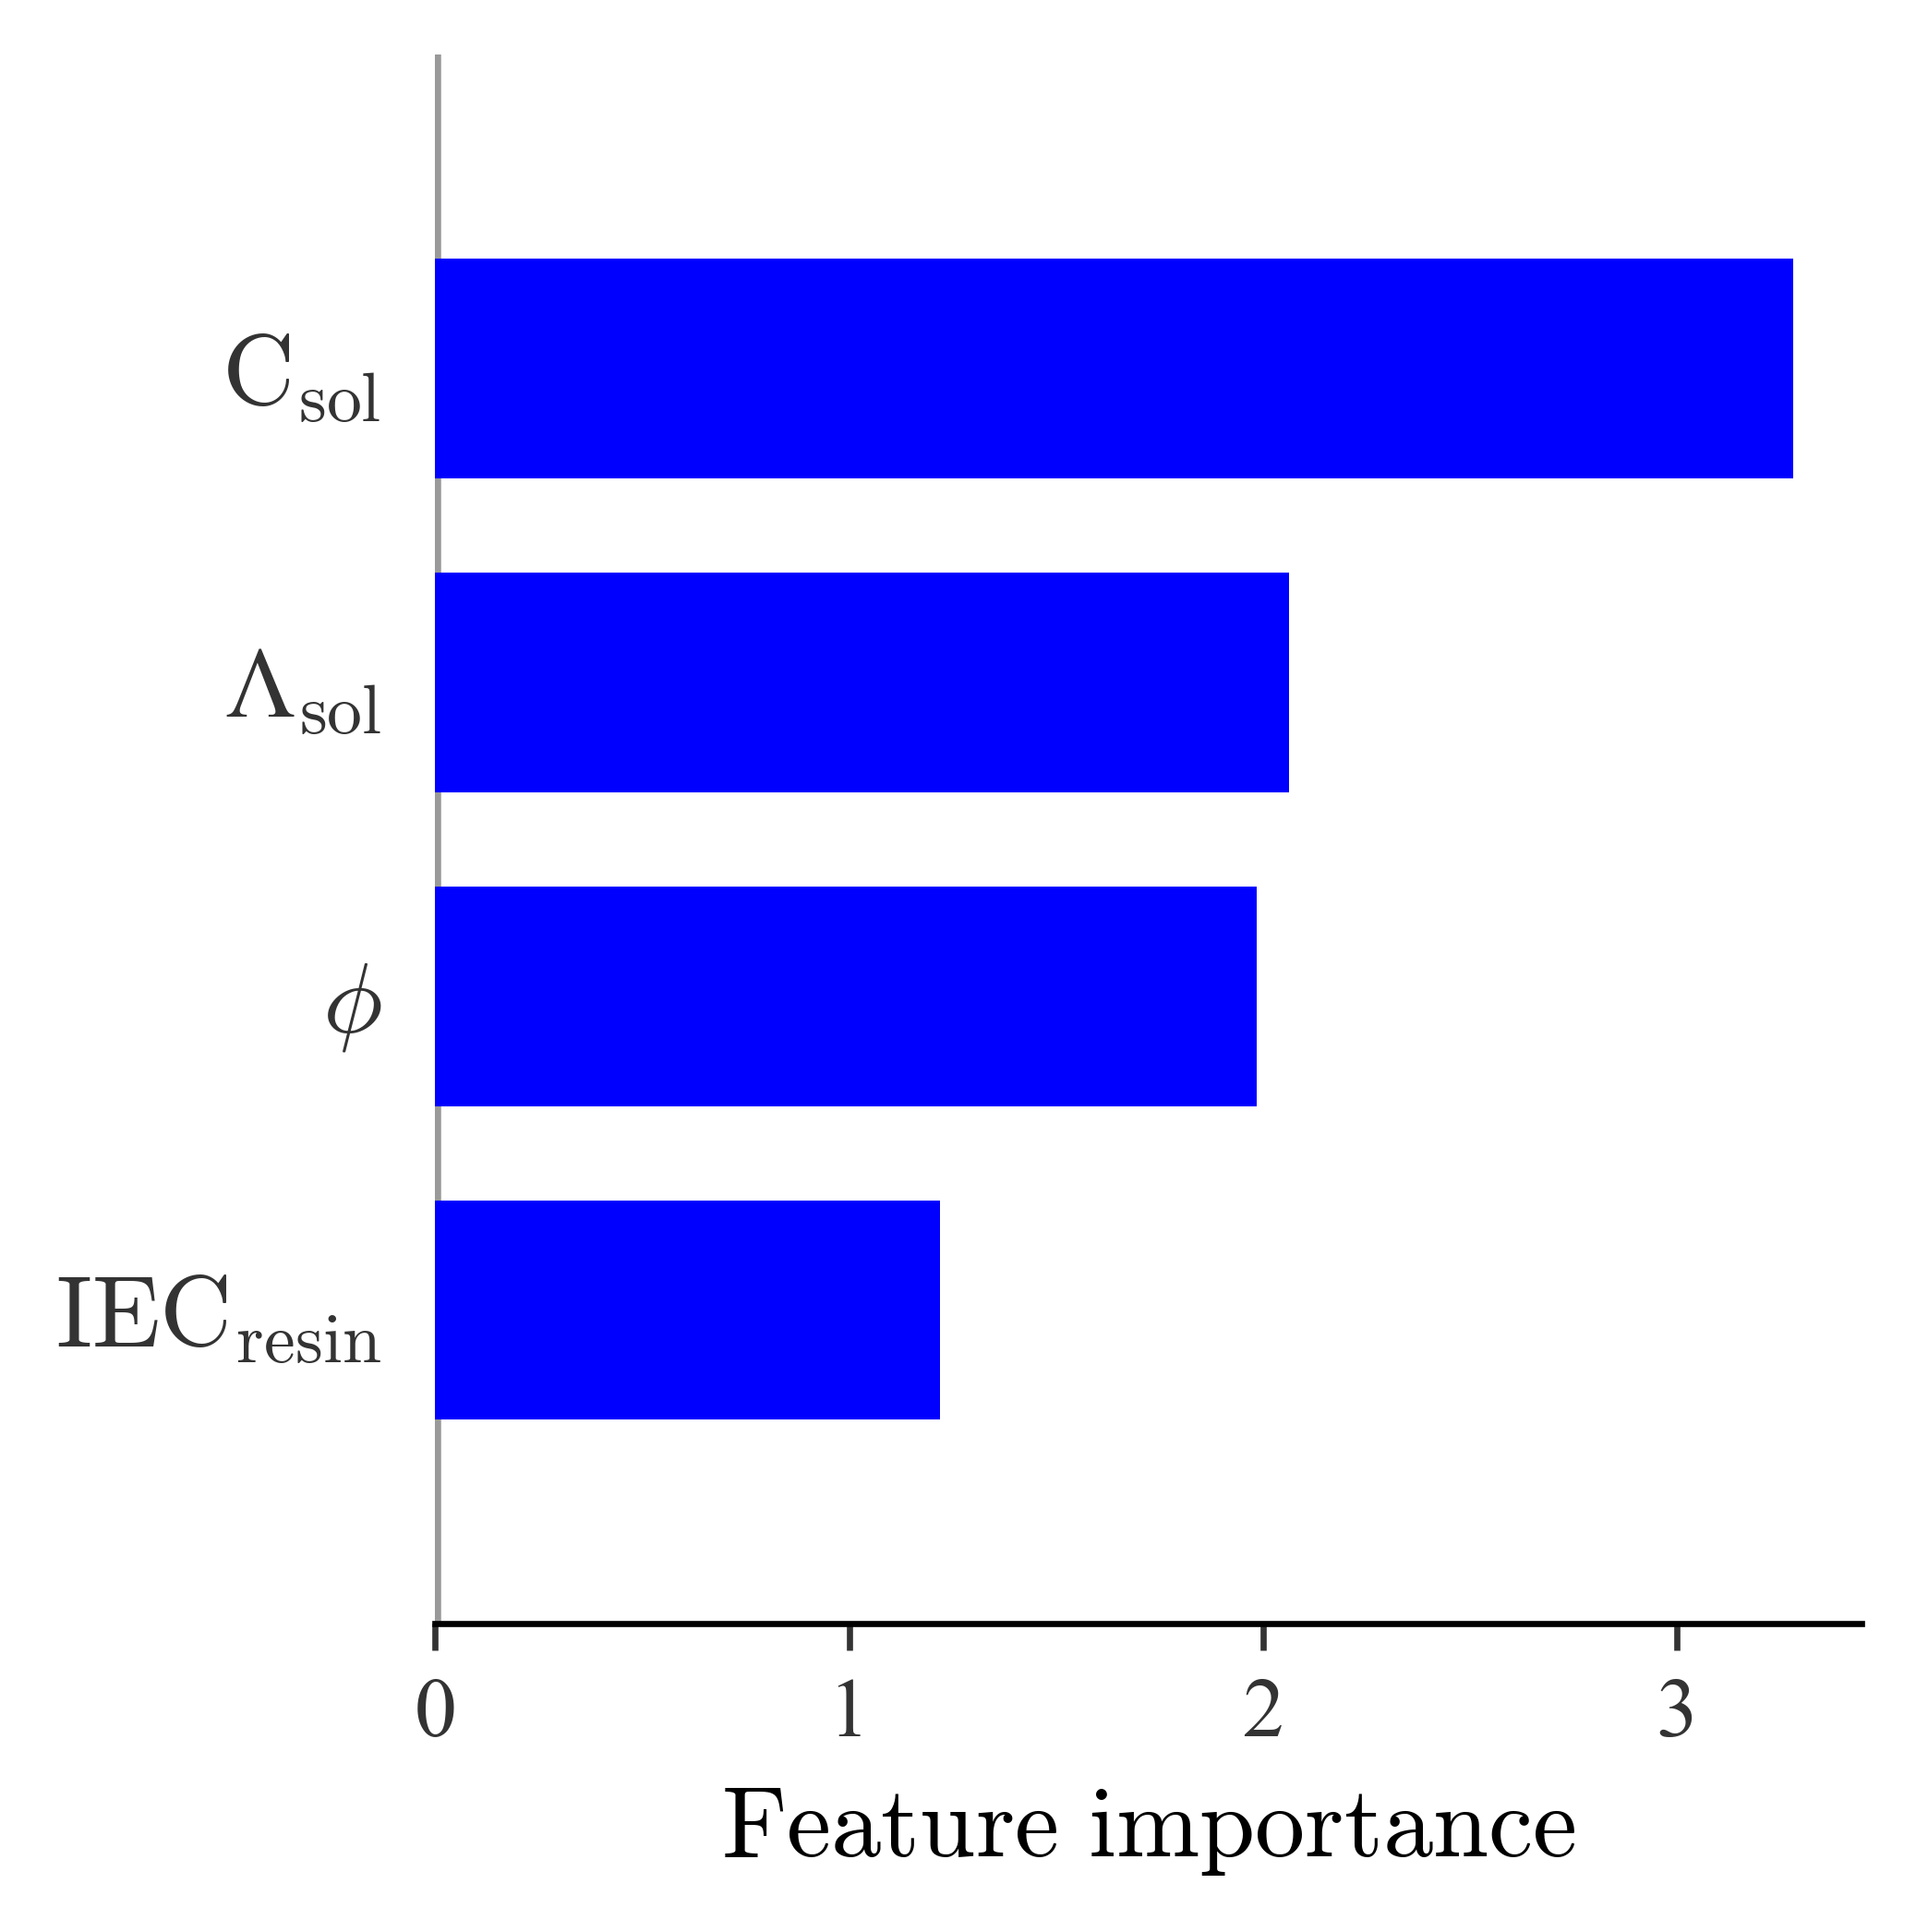

In [45]:
# plot the SHAP values in bee swarm plot
shap_values = shap.TreeExplainer(model_no_earl_stop).shap_values(X_train_shapely)
disp_shap_bar(
    shap_values = shap_values, 
            data = X_full_shapely, 
            title = '', 
            color = 'blue', 
            figsize=(3, 4))

## 2. Early stop

In [46]:
# fit model no training data
model_with_early_stop = XGBRegressor(**best_params)
eval_set = [(X_train, y_train), (X_vali, y_vali)]
# model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=mean_absolute_error, eval_set=eval_set, verbose=True)
model_with_early_stop.fit(X_train, y_train, early_stopping_rounds=1000, eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model_with_early_stop.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = r2_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-rmse:6.88921	validation_1-rmse:4.90569
[1]	validation_0-rmse:6.65089	validation_1-rmse:4.71256
[2]	validation_0-rmse:6.39601	validation_1-rmse:4.57294
[3]	validation_0-rmse:6.19437	validation_1-rmse:4.45233
[4]	validation_0-rmse:6.00345	validation_1-rmse:4.34190
[5]	validation_0-rmse:5.82635	validation_1-rmse:4.27630
[6]	validation_0-rmse:5.65894	validation_1-rmse:4.19163
[7]	validation_0-rmse:5.51743	validation_1-rmse:4.08759
[8]	validation_0-rmse:5.34863	validation_1-rmse:3.96522
[9]	validation_0-rmse:5.18007	validation_1-rmse:3.87723
[10]	validation_0-rmse:5.11091	validation_1-rmse:3.82658
[11]	validation_0-rmse:5.05132	validation_1-rmse:3.81348
[12]	validation_0-rmse:4.90799	validation_1-rmse:3.70537
[13]	validation_0-rmse:4.75584	validation_1-rmse:3.57488
[14]	validation_0-rmse:4.57753	validation_1-rmse:3.45372
[15]	validation_0-rmse:4.43429	validation_1-rmse:3.41273
[16]	validation_0-rmse:4.25979	validation_1-rmse:3.31533
[17]	validation_0-rmse:4.12019	validation

[23]	validation_0-rmse:3.39828	validation_1-rmse:2.78275
[24]	validation_0-rmse:3.27961	validation_1-rmse:2.71221
[25]	validation_0-rmse:3.16712	validation_1-rmse:2.65014
[26]	validation_0-rmse:3.06041	validation_1-rmse:2.60022
[27]	validation_0-rmse:3.01729	validation_1-rmse:2.57168
[28]	validation_0-rmse:2.92229	validation_1-rmse:2.53489
[29]	validation_0-rmse:2.82118	validation_1-rmse:2.49285
[30]	validation_0-rmse:2.73358	validation_1-rmse:2.44043
[31]	validation_0-rmse:2.63411	validation_1-rmse:2.38611
[32]	validation_0-rmse:2.55750	validation_1-rmse:2.35758
[33]	validation_0-rmse:2.46809	validation_1-rmse:2.31021
[34]	validation_0-rmse:2.37617	validation_1-rmse:2.27257
[35]	validation_0-rmse:2.30202	validation_1-rmse:2.22083
[36]	validation_0-rmse:2.27816	validation_1-rmse:2.20111
[37]	validation_0-rmse:2.25849	validation_1-rmse:2.18537
[38]	validation_0-rmse:2.19391	validation_1-rmse:2.16366
[39]	validation_0-rmse:2.13753	validation_1-rmse:2.13321
[40]	validation_0-rmse:2.08498	

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[163]	validation_0-rmse:0.34686	validation_1-rmse:1.01684
[164]	validation_0-rmse:0.34558	validation_1-rmse:1.01534
[165]	validation_0-rmse:0.34373	validation_1-rmse:1.01606
[166]	validation_0-rmse:0.34193	validation_1-rmse:1.01350
[167]	validation_0-rmse:0.34017	validation_1-rmse:1.00802
[168]	validation_0-rmse:0.33942	validation_1-rmse:1.00917
[169]	validation_0-rmse:0.33618	validation_1-rmse:1.00480
[170]	validation_0-rmse:0.33504	validation_1-rmse:1.00393
[171]	validation_0-rmse:0.33171	validation_1-rmse:1.00522
[172]	validation_0-rmse:0.33002	validation_1-rmse:1.00262
[173]	validation_0-rmse:0.32895	validation_1-rmse:0.99847
[174]	validation_0-rmse:0.32750	validation_1-rmse:0.99581
[175]	validation_0-rmse:0.32590	validation_1-rmse:0.99077
[176]	validation_0-rmse:0.32276	validation_1-rmse:0.99130
[177]	validation_0-rmse:0.32179	validation_1-rmse:0.98582
[178]	validation_0-rmse:0.31915	validation_1-rmse:0.97882
[179]	validation_0-rmse:0.31868	validation_1-rmse:0.97659
[180]	validati

In [47]:
y_pred = model_with_early_stop.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"RMSE: {rmse:.2f}")

Accuracy: 91.67%
RMSE: 1.02


In [48]:
y_pred_train = model_with_early_stop.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy_train = r2_score(y_train, predictions_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
print("Train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("Train RMSE: %.2f" % (rmse_train))

Train Accuracy: 99.76%
Train RMSE: 0.35


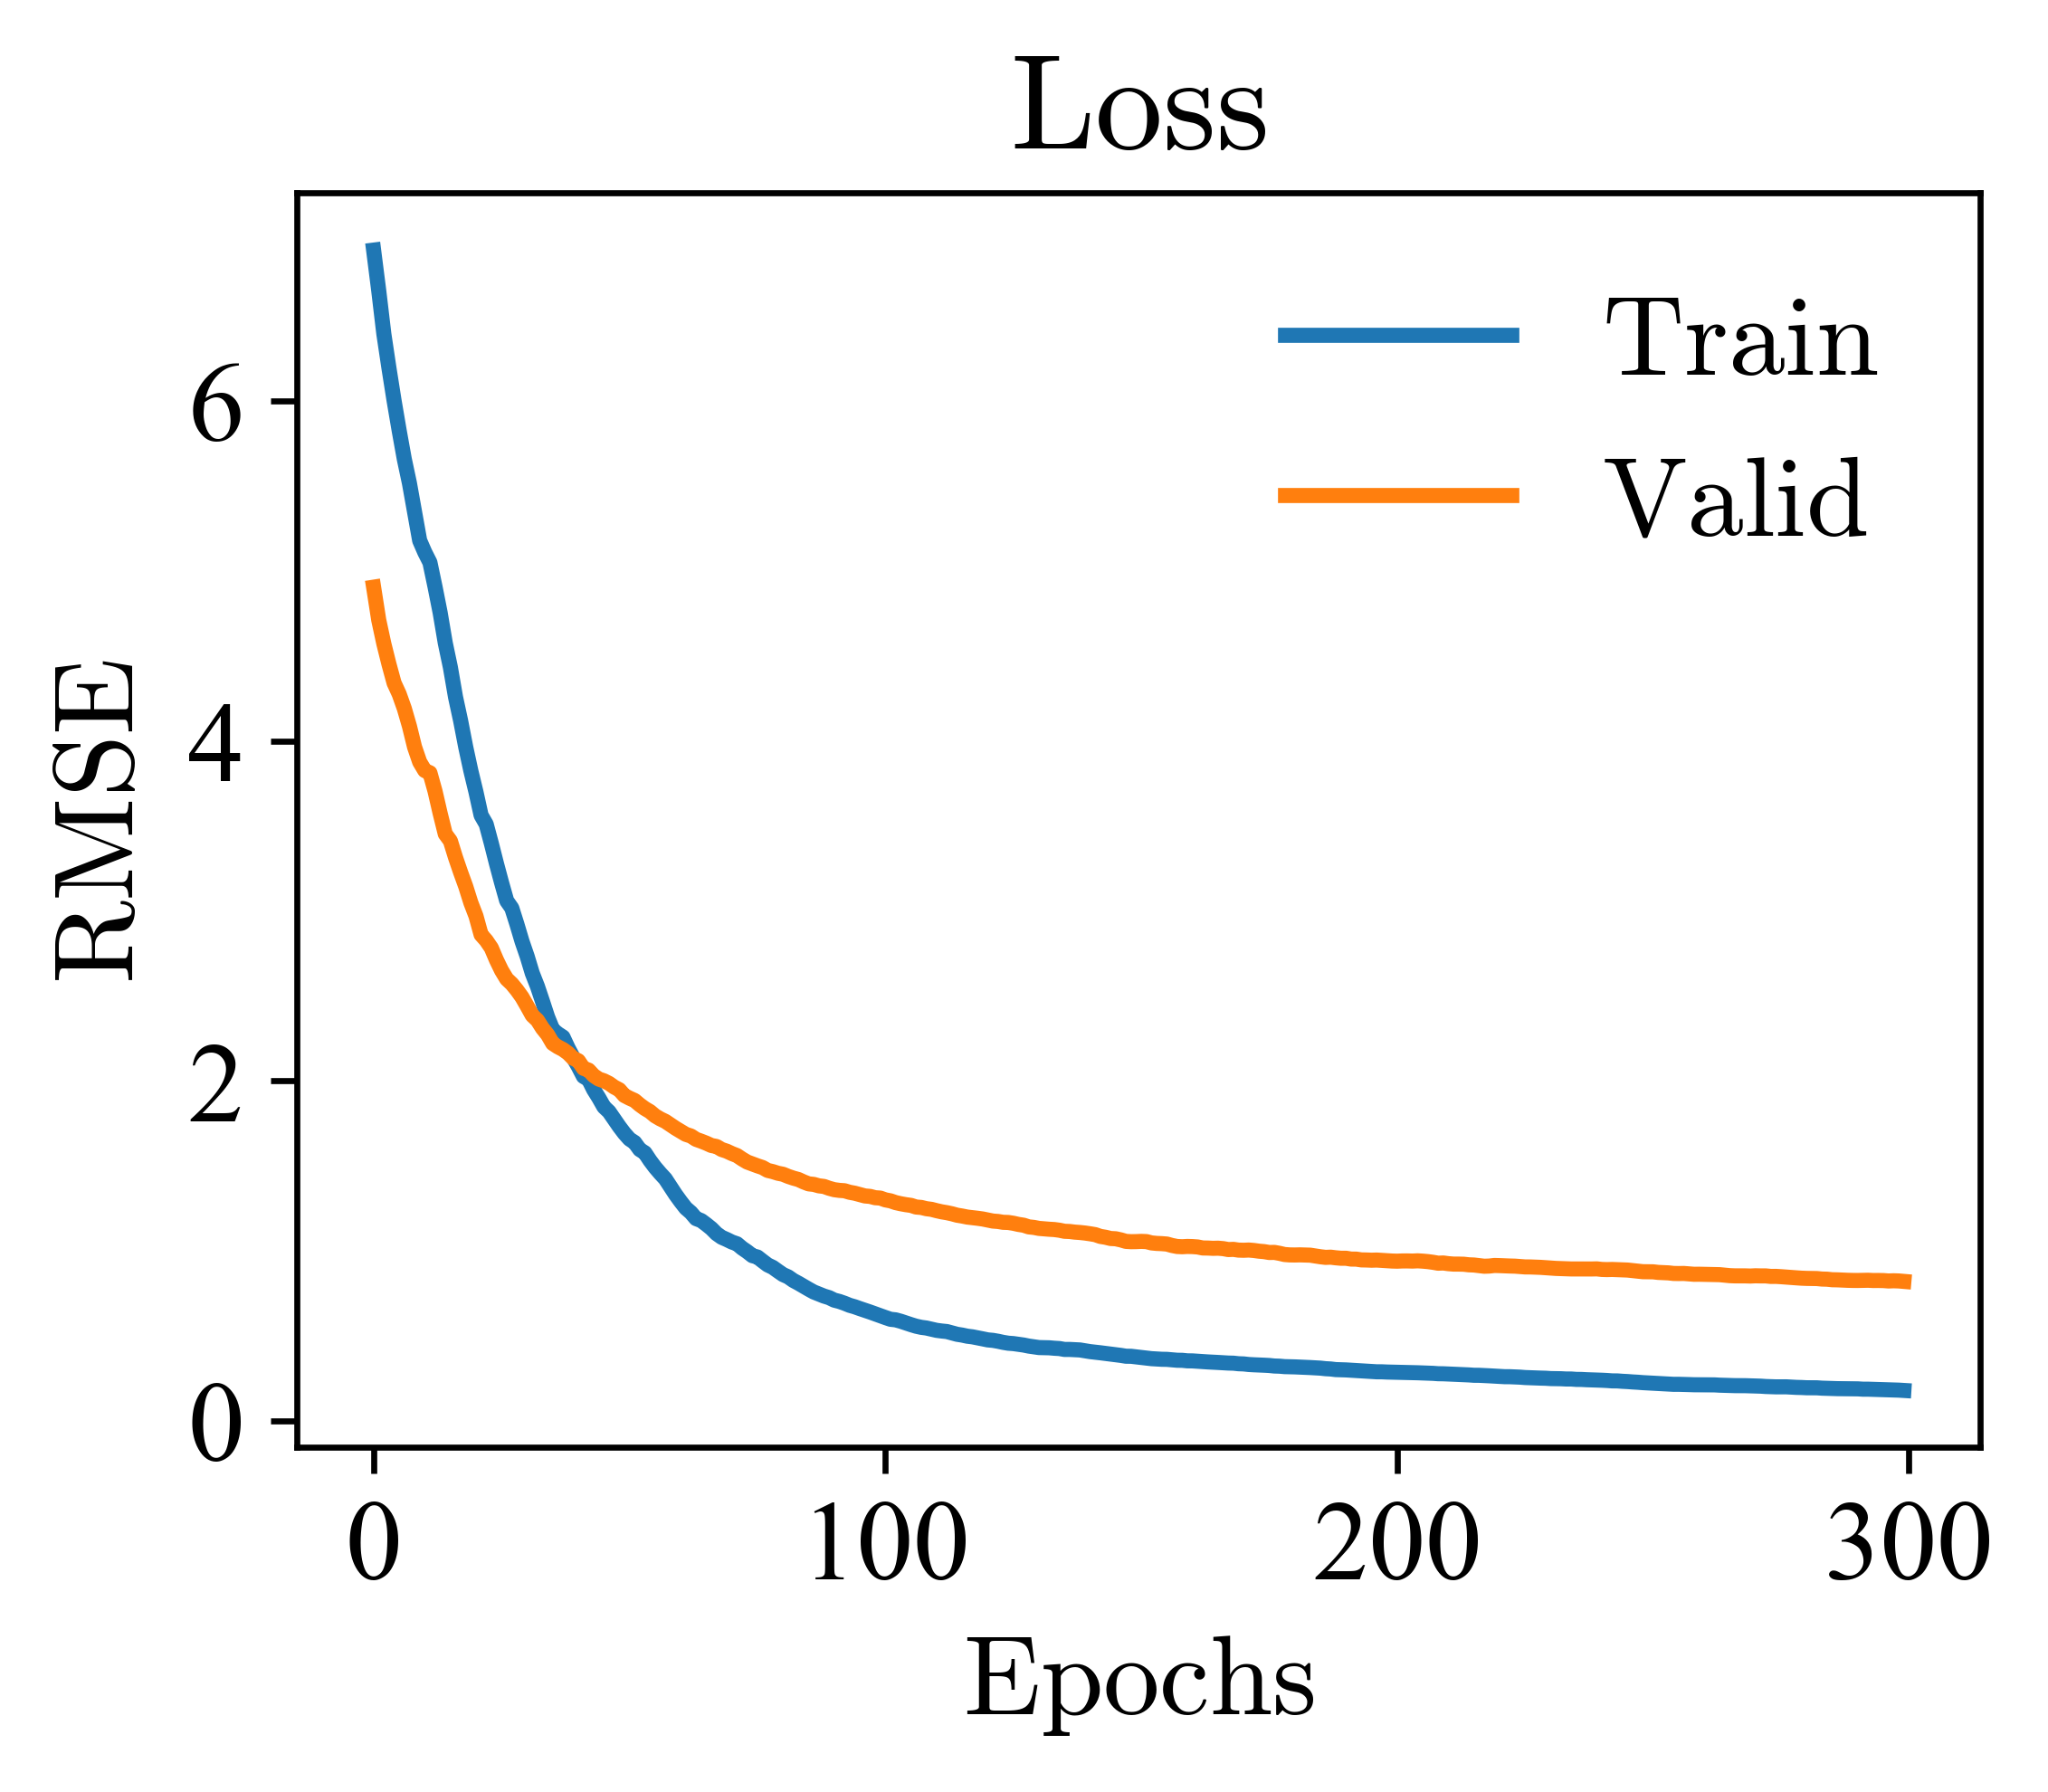

In [49]:
plot_metrics(model_with_early_stop, fontsize=15, dpi=600, figsize=(4, 3))

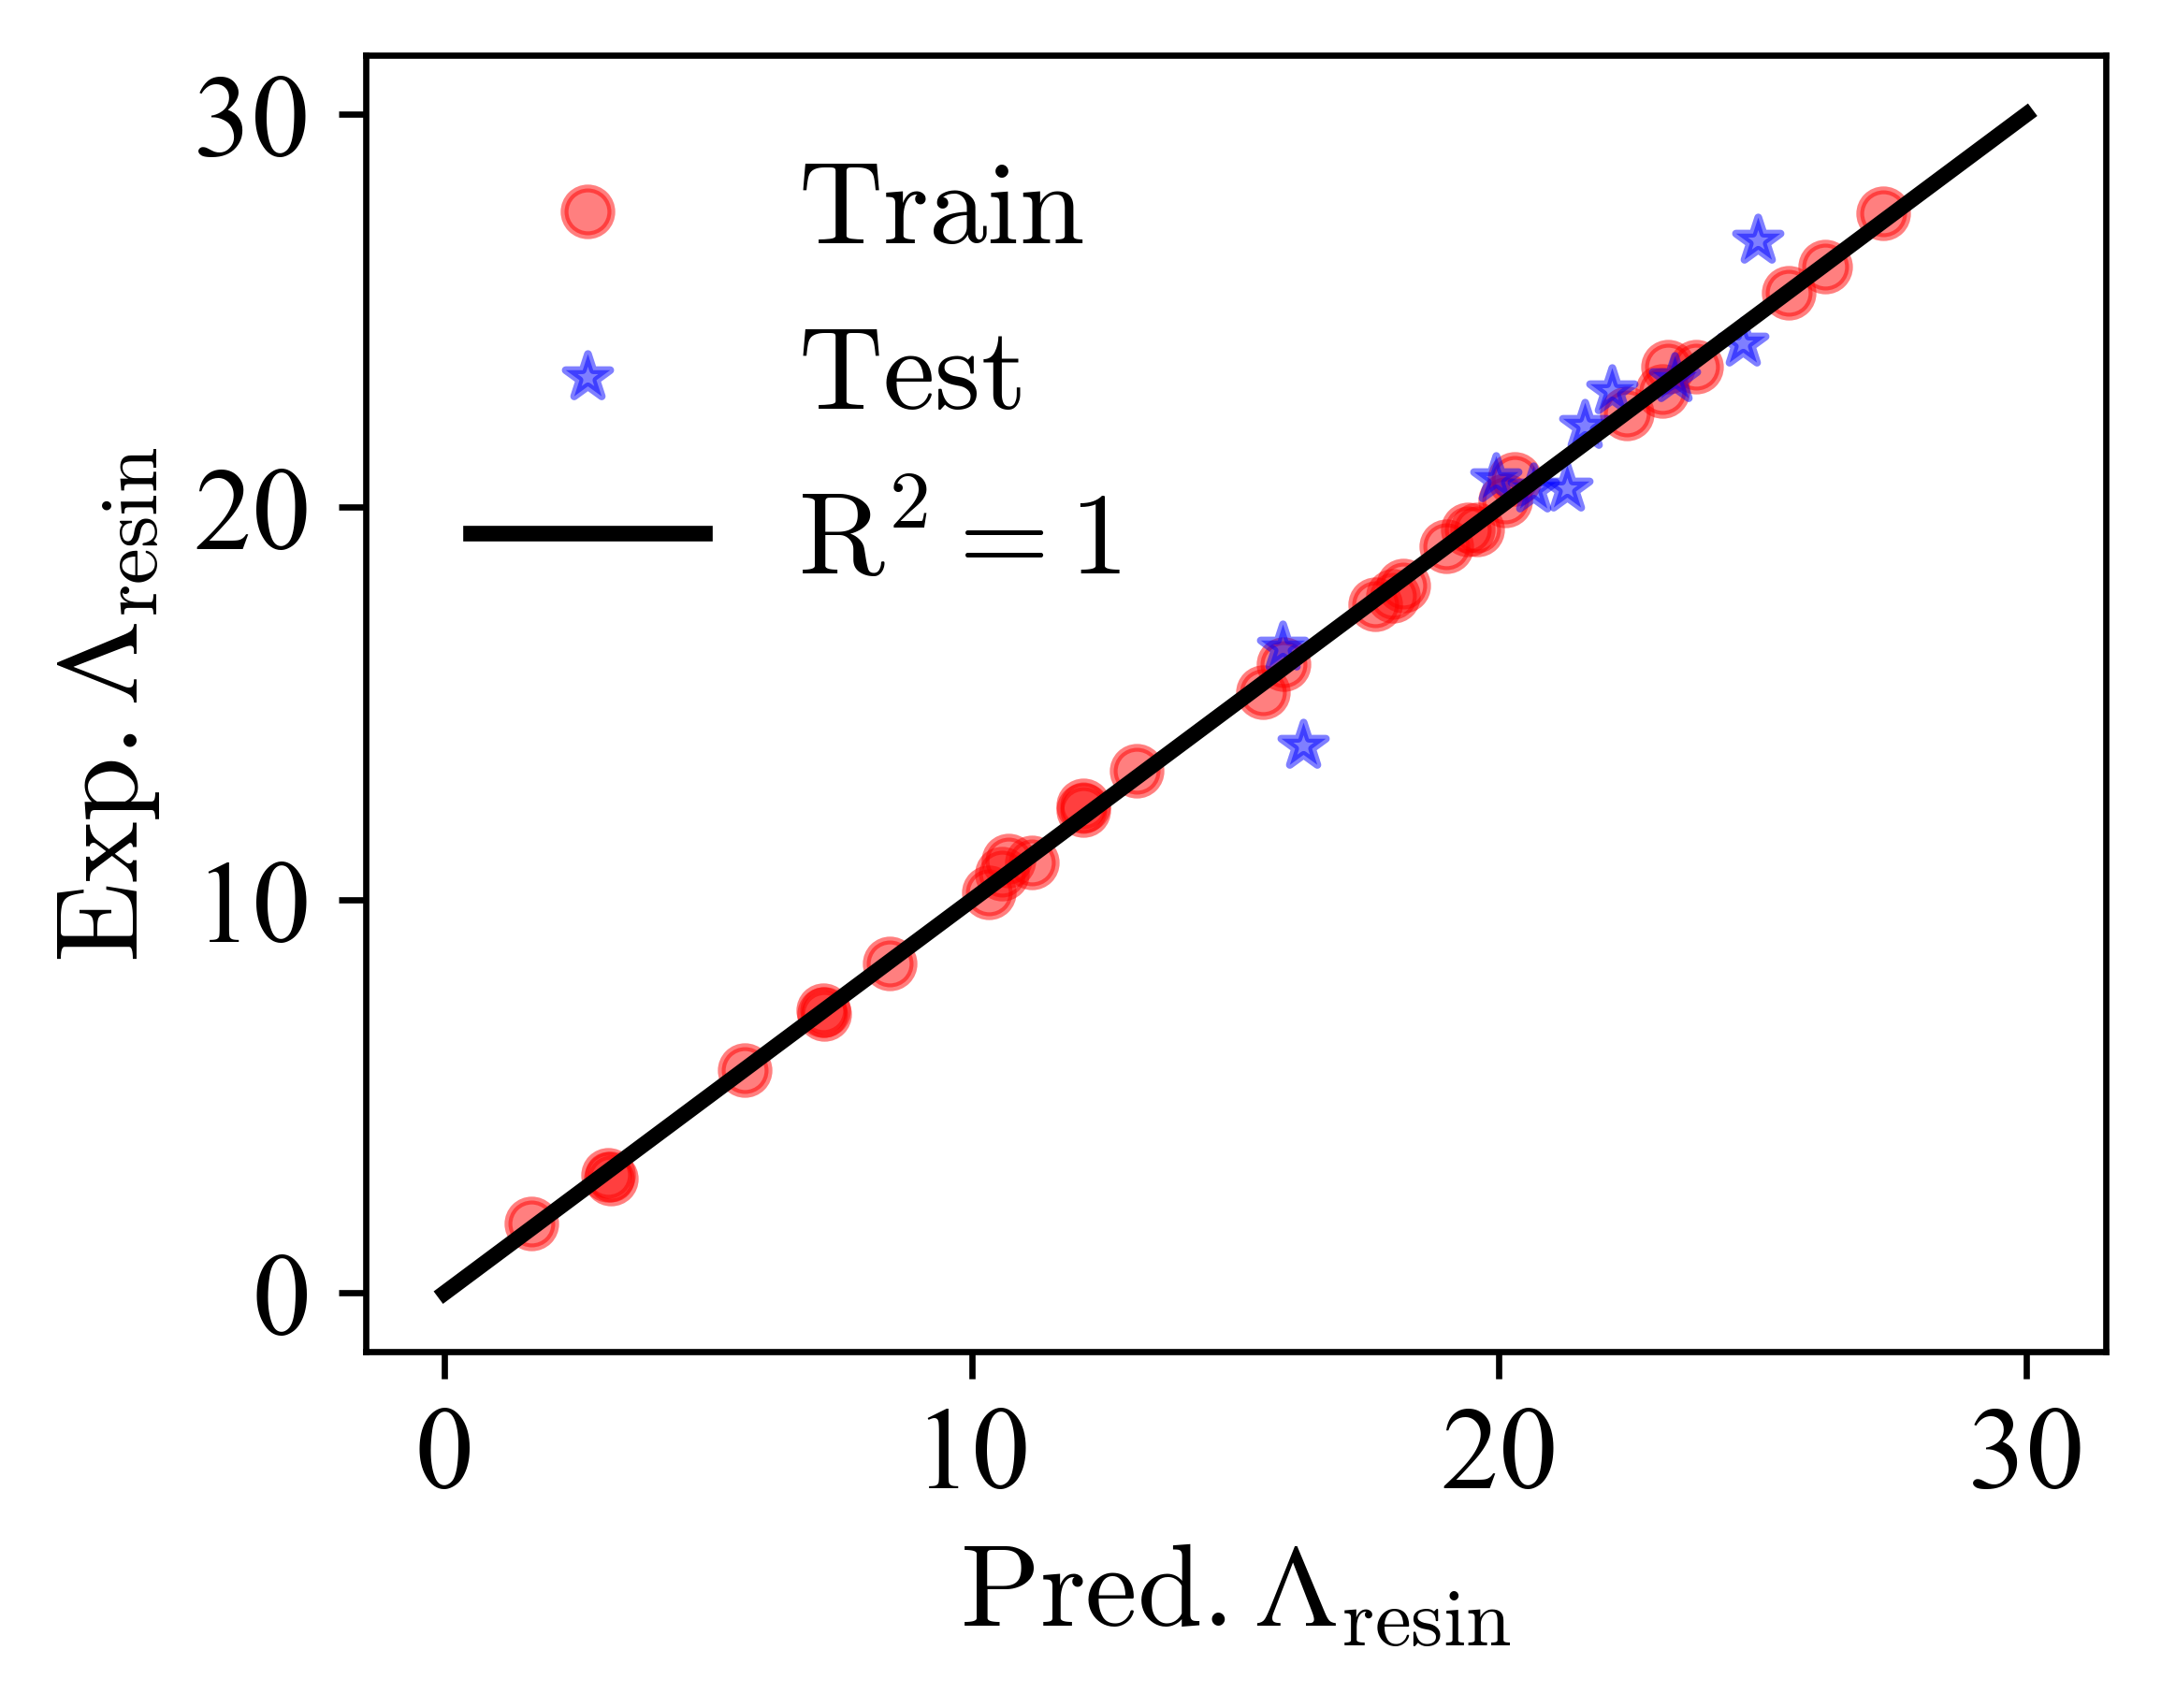

In [50]:
show_prediction(model_with_early_stop, X_train, X_test, y_train, y_test, fontsize=15, figsize=(4, 3))

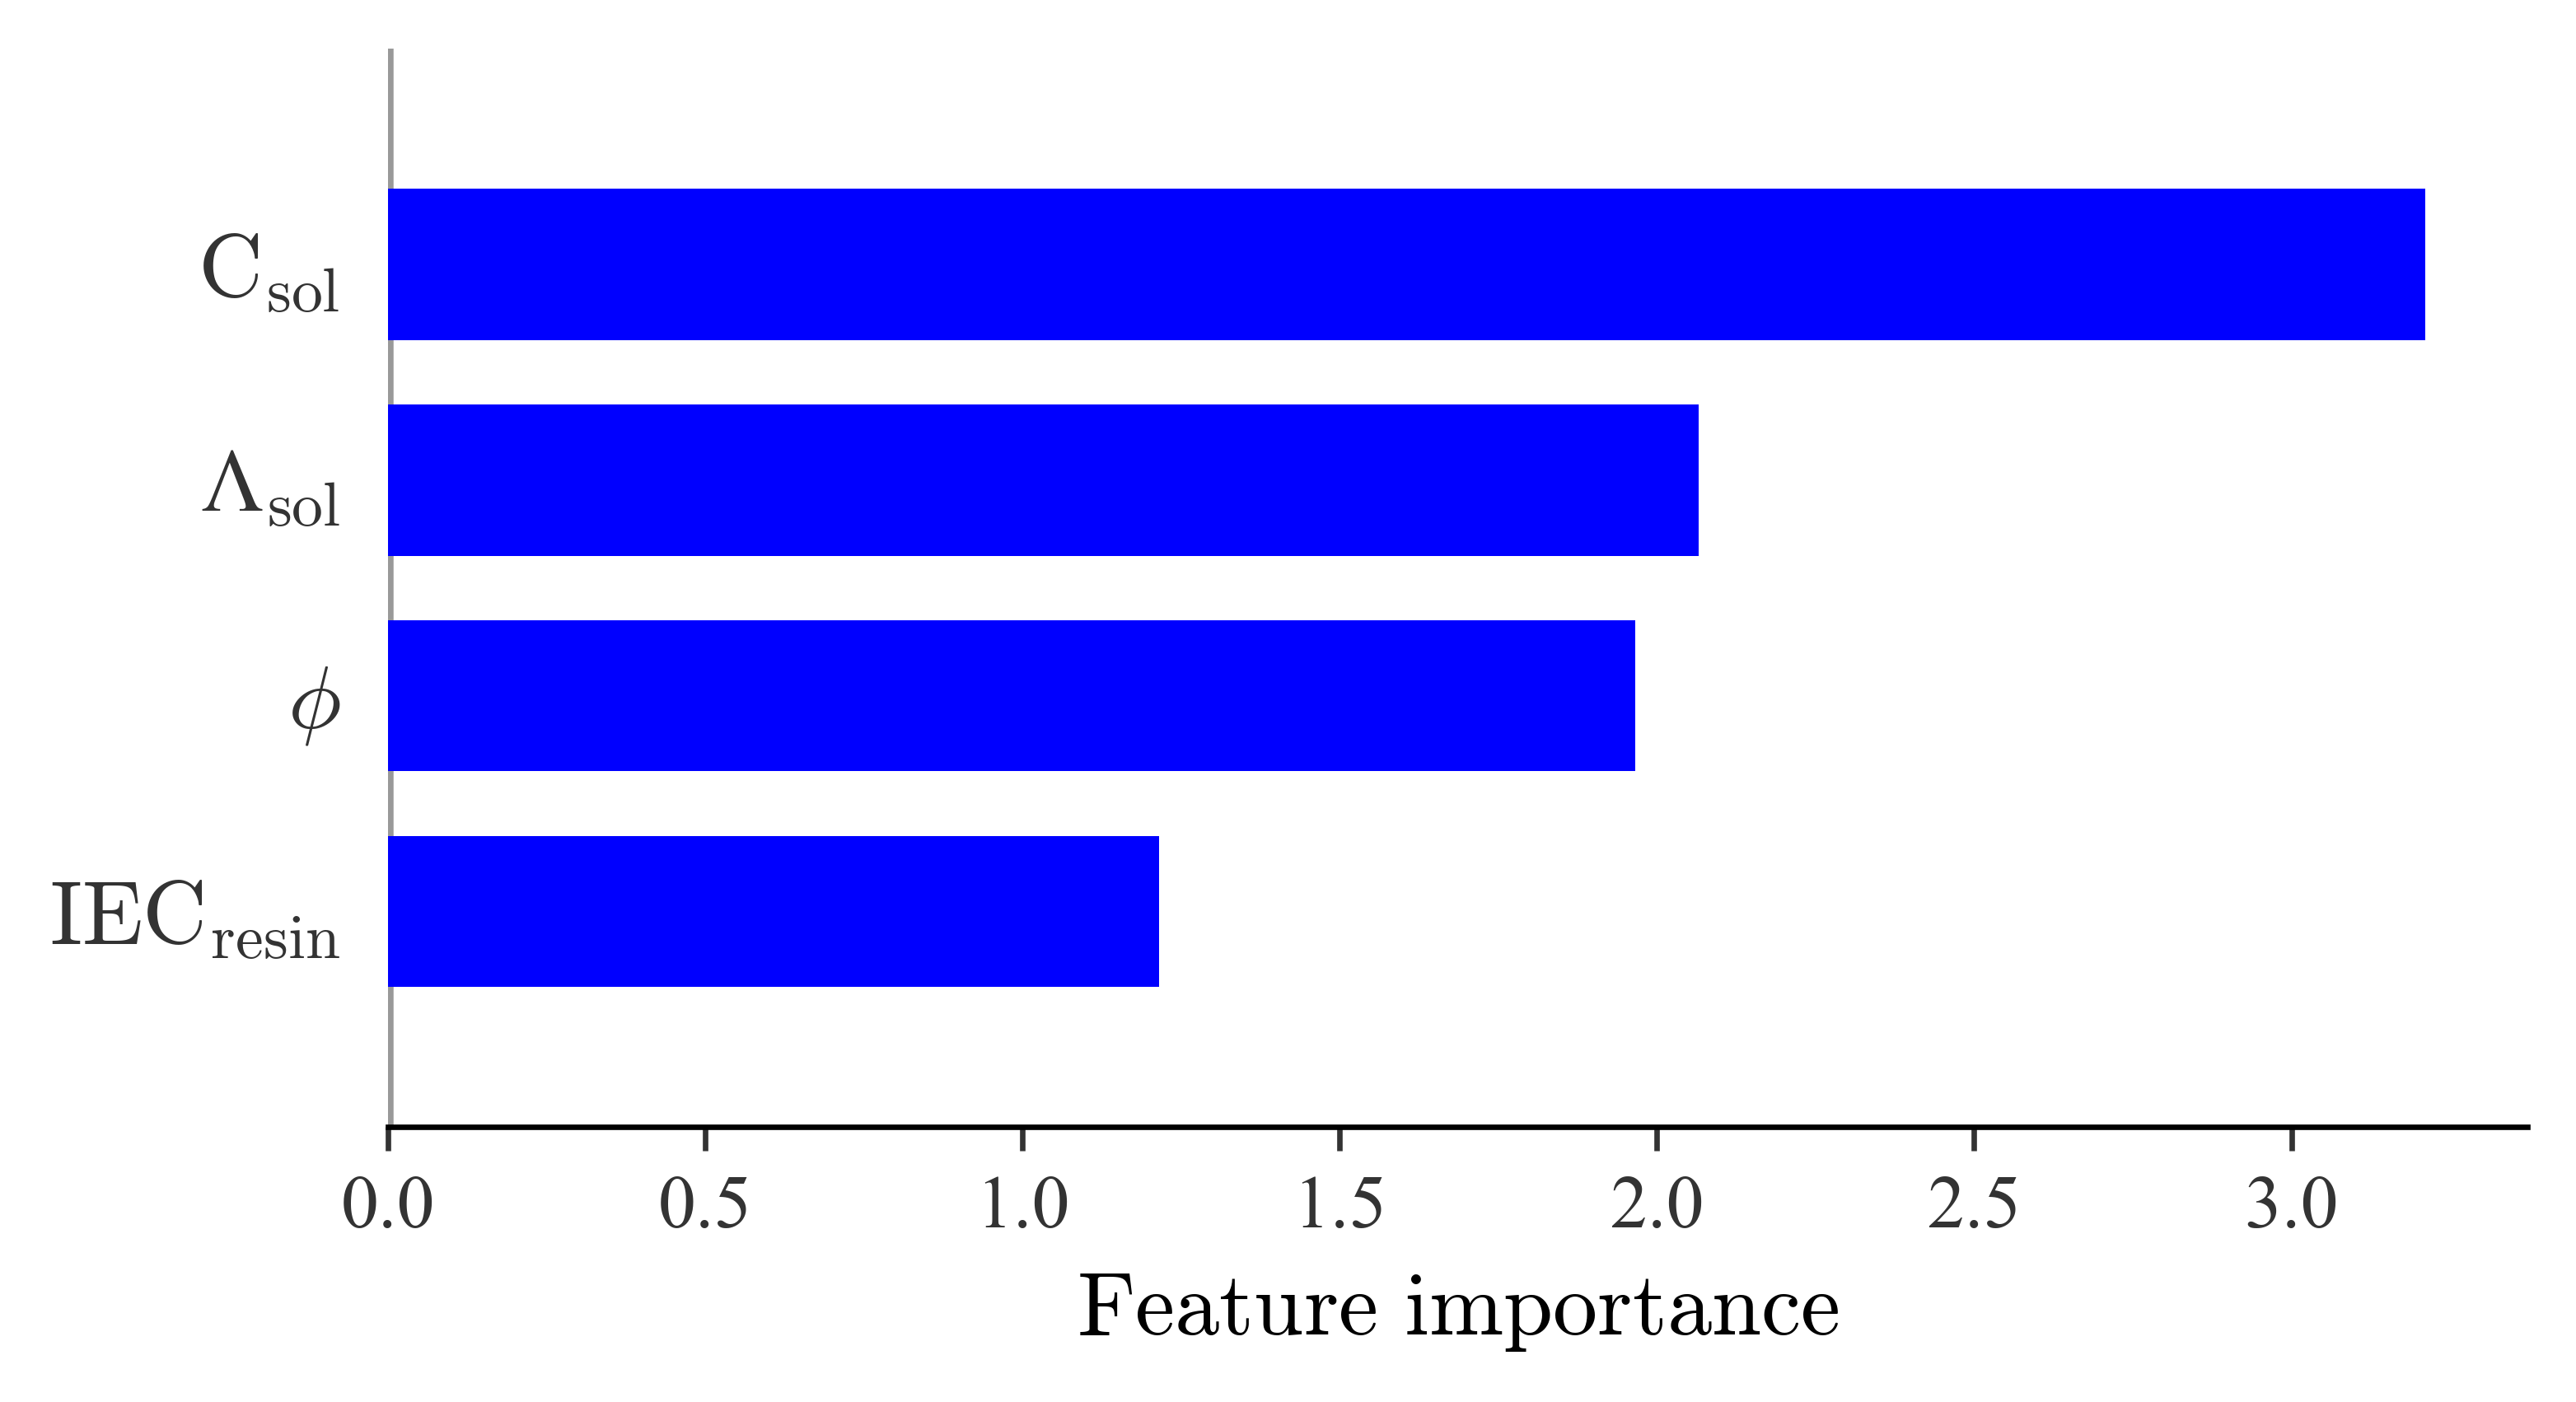

In [54]:
# Fits the explainer
explainer = shap.Explainer(model_with_early_stop.predict, X_train_shapely)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_train_shapely)
# 
disp_shap_bar(
    shap_values = shap_values, 
            data = X_full_shapely, 
            title = '', 
            color = 'blue', 
            figsize=(5, 3))

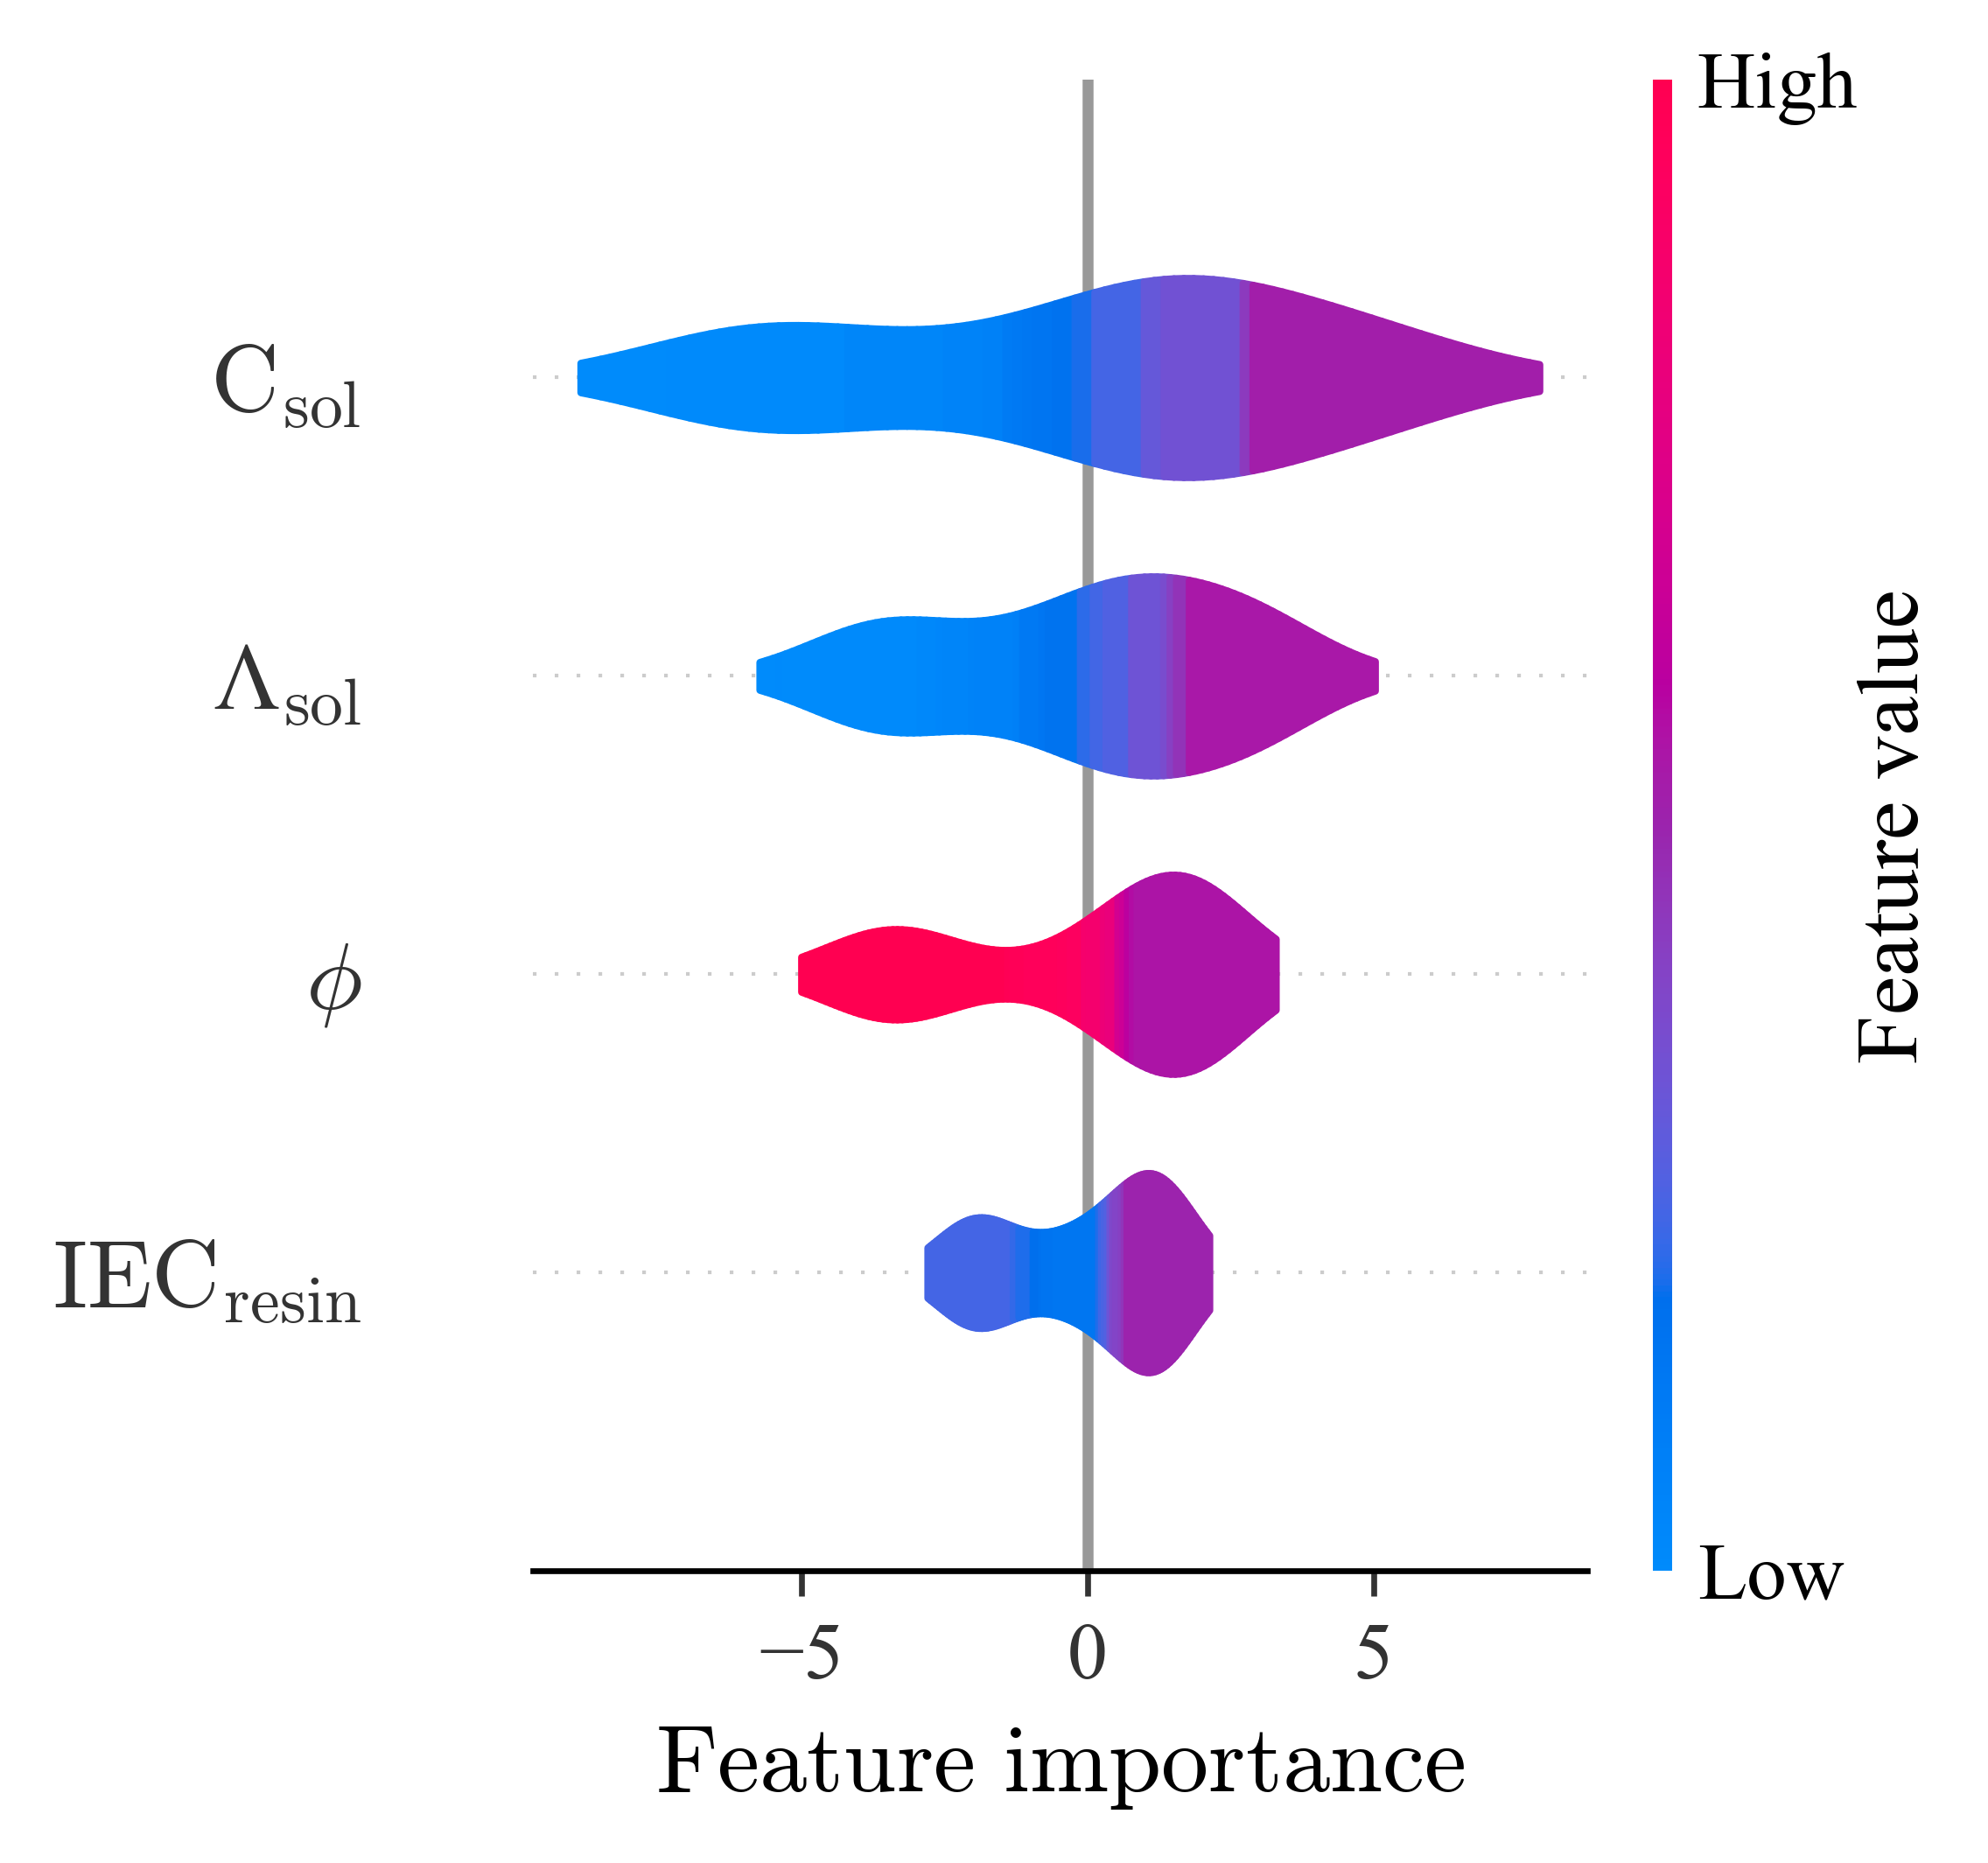

In [52]:
disp_shap_violin(shap_values, title = '', color = 'blue', figsize=(3, 4))

# Dump model

In [30]:
# from pickle import dump


# # save the model
# dump(model_with_early_stop, open('./models/resin_model.pkl', 'wb'))
# # save the scaler
# dump(scaler, open('./models/resin_scaler.pkl', 'wb'))